In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Predictions for Chicago South

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import numpy as np
import descartes

import open_cp.sources.chicago as chicago
import open_cp.geometry

# Wherever "generate_sources.py" put files
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#os.environ["GDAL_DATA"] = os.path.join("..", "..", "..", "..", "..", "..", "Anaconda3", "Library", "share", "gdal")
datadir = os.path.join("//media", "disk", "Data")

In [5]:
chicago.set_data_directory(datadir)
south_side = chicago.get_side("South")

points = chicago.load(os.path.join(datadir, "chicago_two.csv"), {"BURGLARY"}, type="all_other")
points = open_cp.geometry.intersect_timed_points(points, south_side)

## Other setup

Some utility methods for plotting etc.

In [6]:
cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}
yellow_to_red = matplotlib.colors.LinearSegmentedColormap("yellow_to_red", cdict)

def add_outline(ax, colour="black"):
    ax.add_patch(descartes.PolygonPatch(south_side, fc=colour, alpha=0.2))
    ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="black"))

# Recreate Adepeju, Rosser and Cheng:

- Data in just Chicago South side
- Burglary data
- From 1st March 2011 to 6th January 2012
- Evaluate 28th September 2011 – 6th January 2012

## Plot the crime

In [7]:
import open_cp.naive

predictor = open_cp.naive.CountingGridKernel(250)
time_range_mask = ( (points.timestamps >= np.datetime64("2011-03-01T00:00")) &
    (points.timestamps <= np.datetime64("2012-01-07T00:00")) )
predictor.data = points[time_range_mask]
#predictor.region = predictor.data.bounding_box
#predictor.region += open_cp.Point(1000, 150)
risk = predictor.predict()
print("Number of data points:", predictor.data.number_data_points)

Number of data points: 3395


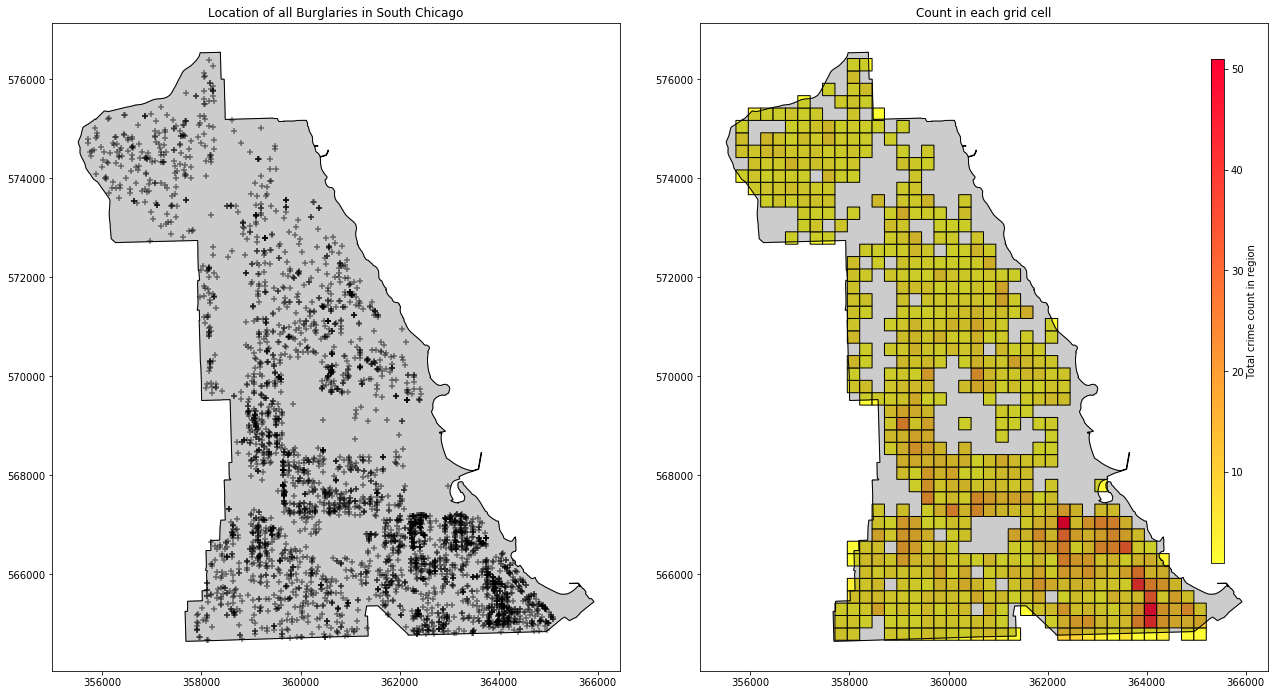

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))
for a in ax:
    add_outline(a)
    a.set_aspect(1)

ax[0].scatter(*predictor.data.coords, marker="+", color="black", alpha=0.5)
matrix = np.ma.masked_where(risk.intensity_matrix==0, risk.intensity_matrix)
mappable = ax[1].pcolor(*risk.mesh_data(), matrix, cmap=yellow_to_red, edgecolor="black", linewidth=1)

# Tedious graph layout...
cax = fig.add_axes([0.9, 0.2, 0.01, 0.7])
cbar = fig.colorbar(mappable, orientation="vertical", cax=cax)
cbar.set_label("Total crime count in region")

ax[0].set_position([0,0.05,0.45,0.9])
ax[1].set_position([0.5,0.05,0.45,0.9])
ax[0].set_title("Location of all Burglaries in South Chicago")
ax[1].set_title("Count in each grid cell")

None

# Using "masked grids" and predictions

We clip our grid to just cover the geographic region of interest, and then make two "naive" predictions:

- Use the `scipy` Gaussidan KDE method
- Use the `naive` predictor-- just base the risk on a count of past crime in that grid cell.

In [9]:
import open_cp.evaluation
import open_cp.geometry
import open_cp.plot

In [10]:
grid = open_cp.data.Grid(xsize=250, ysize=250, xoffset=0, yoffset=0)
masked_grid = open_cp.geometry.mask_grid_by_intersection(south_side, grid)

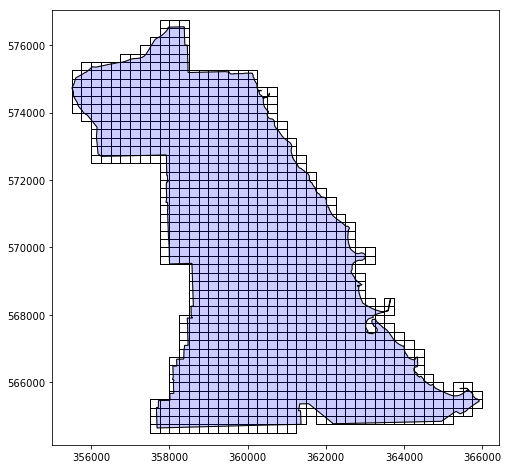

In [11]:
fig, ax  = plt.subplots(figsize=(8,8))
add_outline(ax, colour="Blue")
pc = open_cp.plot.patches_from_grid(masked_grid)
ax.add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
xmin, ymin, xmax, ymax = south_side.bounds
ax.set(xlim=[xmin-500,xmax+500], ylim=[ymin-500,ymax+500])
None

In [12]:
training_time_range_mask = ( (points.timestamps >= np.datetime64("2011-03-01T00:00")) &
    (points.timestamps <= np.datetime64("2011-09-28T00:00")) )

kde_predictor = open_cp.naive.ScipyKDE()
kde_predictor.data = points[training_time_range_mask]
kde_risk = open_cp.predictors.grid_prediction(kde_predictor.predict(), masked_grid)

In [13]:
naive_predictor = open_cp.naive.CountingGridKernel(masked_grid.xsize, region = masked_grid.region())
naive_predictor.data = points[training_time_range_mask]
naive_risk = naive_predictor.predict()
naive_risk.mask_with(masked_grid)

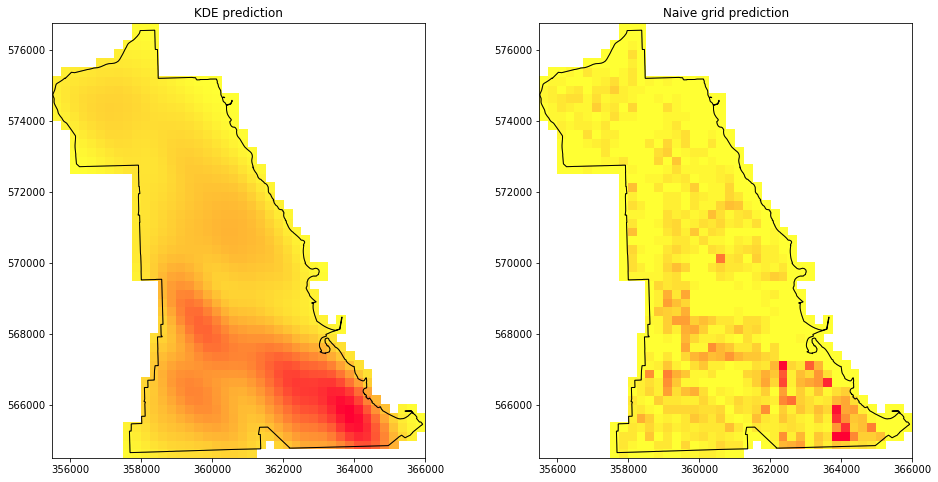

In [14]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    add_outline(a, colour="none")
    
ax[0].pcolormesh(*kde_risk.mesh_data(), kde_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].pcolormesh(*naive_risk.mesh_data(), naive_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("KDE prediction")
ax[1].set_title("Naive grid prediction")
None

### Visualise the top 10% coverage in each case

Note that the scaling of colours is _not_ the same as in the above plots (it has been renormalised.)

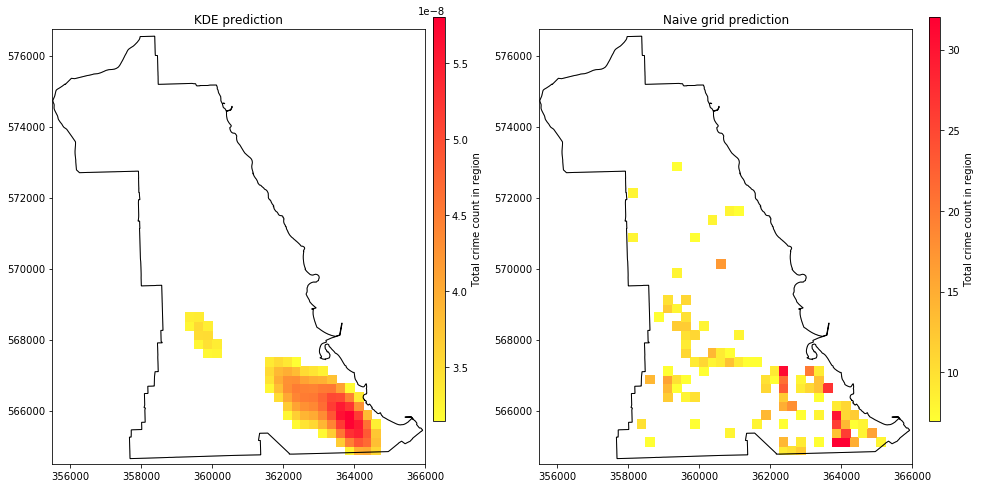

In [15]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    add_outline(a, colour="none")
    
mat = kde_risk.intensity_matrix.copy()
mask = open_cp.evaluation.top_slice(mat, .1)
mat.mask |= ~mask
mappable1 = ax[0].pcolormesh(*kde_risk.mesh_data(), mat, cmap=yellow_to_red)
mat = naive_risk.intensity_matrix.copy()
mask = open_cp.evaluation.top_slice(mat, .1)
mat.mask |= ~mask
mappable2 = ax[1].pcolormesh(*kde_risk.mesh_data(), mat, cmap=yellow_to_red)
ax[0].set_title("KDE prediction")
ax[1].set_title("Naive grid prediction")

cax = fig.add_axes([0.47, 0.2, 0.01, 0.7])
cbar = fig.colorbar(mappable1, orientation="vertical", cax=cax)
cbar.set_label("Total crime count in region")

cax = fig.add_axes([0.9, 0.2, 0.01, 0.7])
cbar = fig.colorbar(mappable2, orientation="vertical", cax=cax)
cbar.set_label("Total crime count in region")

None

# Prohotspot / Retrohotspot

Here we use the "Prospective hotspot" and "Retrospective hotspot" algorithms.

- The Prospective hotspot algorithm is essentially a grid-based, space and time KDE method.
   - We use the default time unit of a "week" and a bandwidth of 8 weeks
   - We adjust the space bandwidth to 2 grid cells-- 500 meters
   
- The retrospective hotspot algorithm is essentially a grid-based, space-only KDE method.
   - We adjust the space bandwidth to 500 meters

In [16]:
import open_cp.prohotspot
import open_cp.retrohotspot

In [17]:
prohotspot_predictor = open_cp.prohotspot.ProspectiveHotSpot(grid=masked_grid)
prohotspot_predictor.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]
prohotspot_predictor.weight = open_cp.prohotspot.ClassicWeight()
prohotspot_predictor.weight.space_bandwidth = 2
prohotspot_risk = prohotspot_predictor.predict(np.datetime64("2011-09-28T00:00"), np.datetime64("2011-09-28T00:00"))
prohotspot_risk.mask_with(masked_grid)

In [18]:
retrohotspot_predictor = open_cp.retrohotspot.RetroHotSpotGrid(grid=masked_grid)
retrohotspot_predictor.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]
retrohotspot_predictor.weight = open_cp.retrohotspot.Quartic(bandwidth=500)
retrohotspot_risk = retrohotspot_predictor.predict(np.datetime64("2011-09-28T00:00"), np.datetime64("2011-09-28T00:00"))
retrohotspot_risk.mask_with(masked_grid)

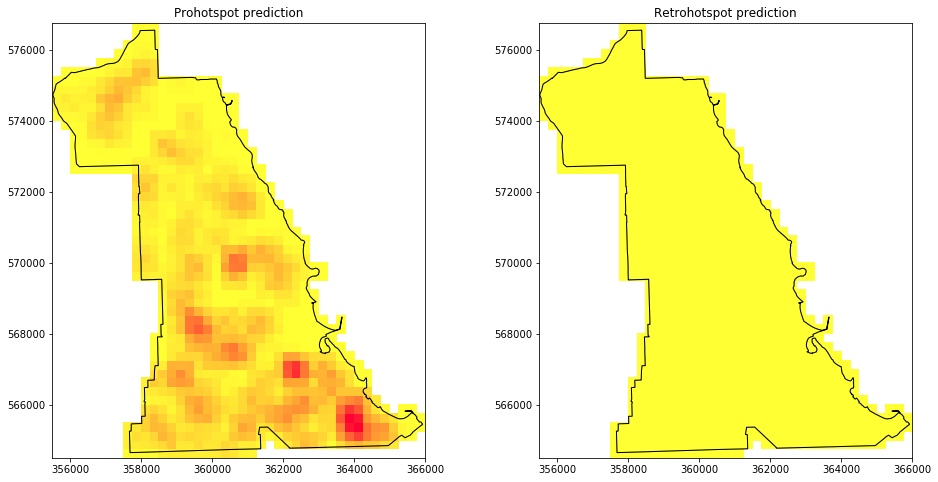

In [19]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    add_outline(a, colour="none")
    
ax[0].pcolormesh(*prohotspot_risk.mesh_data(), prohotspot_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("Prohotspot prediction")
ax[1].pcolormesh(*retrohotspot_risk.mesh_data(), retrohotspot_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].set_title("Retrohotspot prediction")
None

# SeppExp



In [20]:
import open_cp.seppexp

In [21]:
seppexp_trainer = open_cp.seppexp.SEPPTrainer(grid=masked_grid)
seppexp_trainer.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]
sepp_exp_predictor = seppexp_trainer.train(cutoff_time = np.datetime64("2011-09-28T00:00"), iterations=1000)
sepp_exp_predictor.data = points[points.timestamps >= np.datetime64("2011-03-01T00:00")]

In [22]:
sepp_exp_risk = sepp_exp_predictor.predict(np.datetime64("2011-09-28T00:00"))
sepp_exp_risk.mask_with(masked_grid)
sepp_exp_risk_back = sepp_exp_predictor.background_prediction()
sepp_exp_risk_back.mask_with(masked_grid)

### Iterpretting the computed parameters

Remember that the "risk" is a sum of the background rate (see the plot below) and the sum "excitations" which are boosts to the background rate from previous events; these are $\theta \omega e^{-\omega \Delta t}$ where $\Delta t$ is the time since the previous event.

The background rate is around $10^{-4}$ to $10^{-5}$.  We see blw that $\omega \approx 1/50$, or say, about 1 hour (we use "minutes" as the time unit).  Then $\theta \omega \approx 2.10^{-4}$ so around 2 to 20 times the background rate.

Ah, so the problem is that after an hour, the risk decays to $\approx e^{-1} \approx 1/3$.  So after two hours, it decays to $1/9$, and so forth.  In practise, we get no difference between the background rate and the total rate.

In [23]:
sepp_exp_predictor.theta, sepp_exp_predictor.omega, sepp_exp_predictor.theta * sepp_exp_predictor.omega

(0.0098839545492143948, 0.020114393379129038, 0.00019880974994433036)

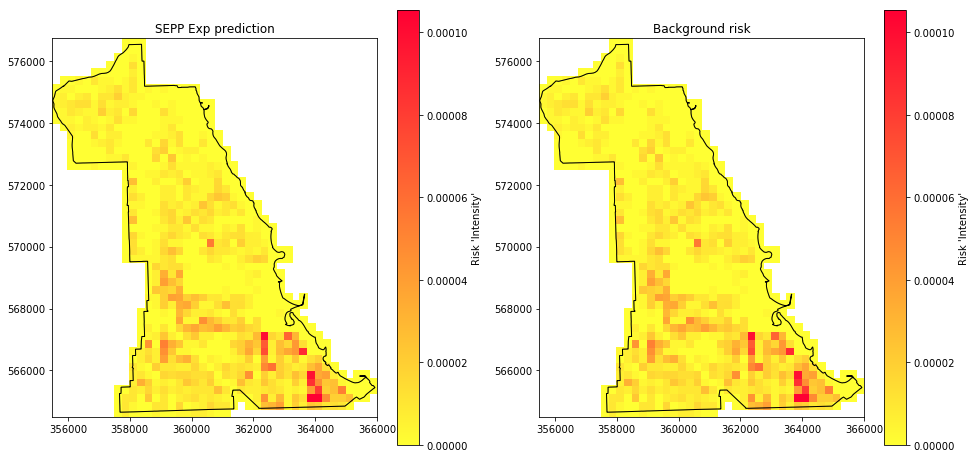

In [24]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    add_outline(a, colour="none")
    
mappable = ax[0].pcolormesh(*sepp_exp_risk.mesh_data(), sepp_exp_risk.intensity_matrix, cmap=yellow_to_red)
cbar = fig.colorbar(mappable, orientation="vertical", ax=ax[0])
cbar.set_label("Risk 'Intensity'")
ax[0].set_title("SEPP Exp prediction")
mappable = ax[1].pcolormesh(*sepp_exp_risk_back.mesh_data(), sepp_exp_risk_back.intensity_matrix, cmap=yellow_to_red)
cbar = fig.colorbar(mappable, orientation="vertical", ax=ax[1])
cbar.set_label("Risk 'Intensity'")
ax[1].set_title("Background risk")

None

# Space Time Scan

In [26]:
import open_cp.stscan

In [34]:
sts_trainer = open_cp.stscan.STSTrainer()
sts_trainer.data = points[training_time_range_mask]
sts_trainer.geographic_population_limit = 1.0
sts_trainer.geographic_radius_limit = 251
sts_trainer.time_max_interval = np.timedelta64(28, "D")
sts_trainer.time_population_limit = 1.0

sts_trainer = sts_trainer.bin_timestamps(np.datetime64("2011-03-01T00:00"), np.timedelta64(1,"D"))
sts_trainer = sts_trainer.grid_coords(masked_grid.region(), masked_grid.xsize)
sts_trainer.region = masked_grid.region()
sts_predictor = sts_trainer.predict(max_clusters=20)

In [35]:
for c, t, s, _ in zip(sts_predictor.clusters, sts_predictor.time_ranges, sts_predictor.statistics, range(5)):
    print(c,t[0],s)

Cluster(centre=array([ 357875.,  575375.]), radius=250.0) 2011-09-12T00:00:00.000 5.20331606644
Cluster(centre=array([ 361625.,  569625.]), radius=250.0) 2011-09-15T00:00:00.000 4.39868192128
Cluster(centre=array([ 363875.,  565375.]), radius=0.0) 2011-09-15T00:00:00.000 4.39867390508
Cluster(centre=array([ 361375.,  566625.]), radius=0.0) 2011-09-18T00:00:00.000 4.1850544938
Cluster(centre=array([ 360625.,  569875.]), radius=250.0) 2011-09-03T00:00:00.000 3.83637033136


# SatScan result

From SaTScan, for this data, the first cluster is:

    1.Location IDs included.: 334, 203
      Coordinates / radius..: (358125,575375) / 250.00
      Time frame............: 2011/9/12 to 2011/9/27
      Number of cases.......: 4
      Expected cases........: 0.36
      Observed / expected...: 11.15
      Test statistic........: 6.006317
      P-value...............: 0.476
      Recurrence interval...: 2 days
      
Which is the same disk and time range as we find, but _not_ the same statistic.  After some digging, what appears to be happening is that SaTScan is ignoring some of other events which are _exactly_ 250 metres from the centre (remember that we moved all events to a regular grid of size 250m).

In [25]:
sts_trainer.to_satscan("chicago")

In [26]:
with open("chicago.geo", "r") as file:
    for row in file:
        i, x, y = row.split()
        if int(i) in {334, 203}:
            print(x,y)

357875.0 575375.0
358125.0 575375.0


In [47]:
x, y = 358125, 575375

space_mask = np.sqrt((sts_trainer.data.xcoords - x) ** 2 + (sts_trainer.data.ycoords - y) ** 2) <= 250
time_mask = sts_trainer.data.timestamps >= np.datetime64("2011-09-12T00:00")

print("In space mask:",
      set( (x,y) for (x,y) in sts_trainer.data.coords.T[space_mask]))

print("In time range: {}, in space range: {}".format(np.sum(time_mask), np.sum(space_mask)))
expected = np.sum(time_mask) * np.sum(space_mask) / sts_trainer.data.number_data_points
actual = np.sum(time_mask & space_mask)
print("Actual count: {}, expected count: {}".format(actual, expected))
print("Stat:",sts_trainer._statistic(actual, expected, sts_trainer.data.number_data_points))

In space mask: {(357875.0, 575375.0), (358125.0, 575625.0), (358125.0, 575375.0), (358125.0, 575125.0)}
In time range: 211, in space ranege: 9
Actual count: 4, expected count: 0.8073979591836735
Stat: 3.21049833946


In [49]:
# Force the "disk" to just contain the two events which SaTScan found.  This gives exactly the
# same statistic...

allowed = { (358125.0,575375.0), (357875.0,575375.0) }
space_mask = np.asarray([(x,y) in allowed for x,y in sts_trainer.data.coords.T])

print("In space mask:",
      set( (x,y) for (x,y) in sts_trainer.data.coords.T[space_mask]))

#print(np.sum(time_mask), np.sum(space_mask))
#expected = np.sum(time_mask) * np.sum(space_mask) / sts_trainer.data.number_data_points
#actual = np.sum(time_mask & space_mask)
#print(actual, expected)
#sts_trainer._statistic(actual, expected, sts_trainer.data.number_data_points)
print("In time range: {}, in space range: {}".format(np.sum(time_mask), np.sum(space_mask)))
expected = np.sum(time_mask) * np.sum(space_mask) / sts_trainer.data.number_data_points
actual = np.sum(time_mask & space_mask)
print("Actual count: {}, expected count: {}".format(actual, expected))
print("Stat:",sts_trainer._statistic(actual, expected, sts_trainer.data.number_data_points))

In space mask: {(357875.0, 575375.0), (358125.0, 575375.0)}
In time range: 211, in space range: 4
Actual count: 4, expected count: 0.358843537414966
Stat: 6.00631658237


## Onwards: produce a risk plot

In [36]:
sts_risk = sts_predictor.grid_prediction(masked_grid.xsize)
sts_risk.mask_with(masked_grid)

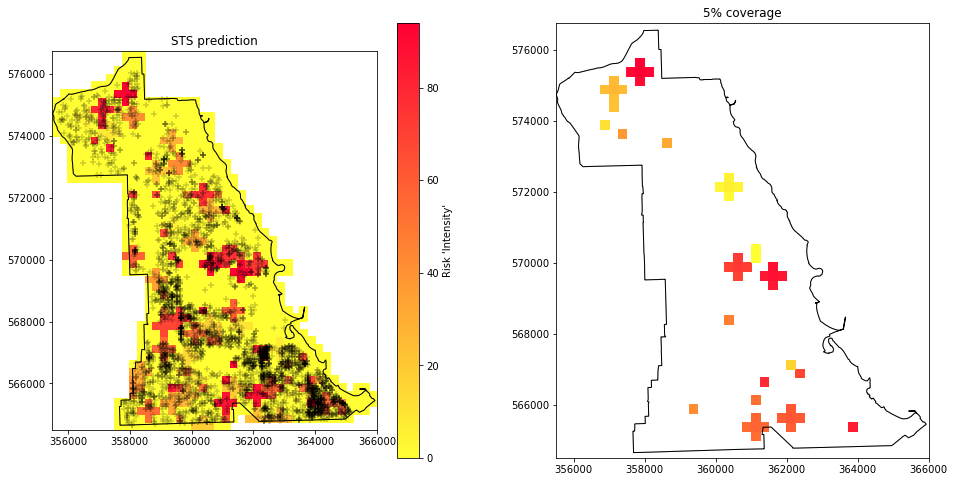

In [37]:
def plot_sts_risk(sts_risk):
    fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

    for a in ax:
        a.set_aspect(1)
        add_outline(a, colour="none")

    mappable = ax[0].pcolormesh(*sts_risk.mesh_data(), sts_risk.intensity_matrix, cmap=yellow_to_red)
    cbar = fig.colorbar(mappable, orientation="vertical", ax=ax[0])
    cbar.set_label("Risk 'Intensity'")
    ax[0].set_title("STS prediction")

    pts = sts_trainer.data
    pts = points[points.timestamps <= np.datetime64("2011-09-28T00:00")]
    ax[0].scatter(*pts.coords, marker="+", color="black", alpha=0.2)

    mat = sts_risk.intensity_matrix.copy()
    mask = open_cp.evaluation.top_slice(mat, 5/100)
    mat.mask |= ~mask
    ax[1].pcolormesh(*sts_risk.mesh_data(), mat, cmap=yellow_to_red)
    ax[1].set_title("5% coverage")
    
plot_sts_risk(sts_risk)

## Non gridded data

For comparison, we now have `stscan` code which is fast enough to consider the actual data, without aligning it to a grid.

In [38]:
sts_trainer = open_cp.stscan.STSTrainer()
sts_trainer.data = points[training_time_range_mask]
sts_trainer.geographic_population_limit = 1.0
sts_trainer.geographic_radius_limit = 251
sts_trainer.time_max_interval = np.timedelta64(28, "D")
sts_trainer.time_population_limit = 1.0

sts_trainer.region = masked_grid.region()
sts_predictor = sts_trainer.predict(max_clusters=20)
sts_risk = sts_predictor.grid_prediction(masked_grid.xsize)
sts_risk.mask_with(masked_grid)

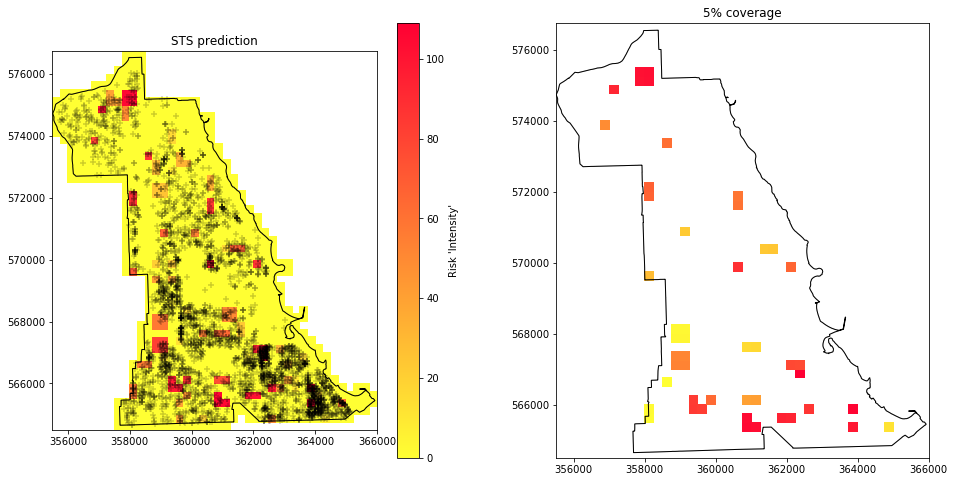

In [39]:
plot_sts_risk(sts_risk)

# Scoring predictions

For the moment, we shall consider the "hit rate":

- For a given `x` find the top `x`% of grid cells by risk
- For the next day, see how many events we thus capture.

In [33]:
start = np.datetime64("2011-09-28T00:00")
length = np.timedelta64(1, "D")

rates = dict()
while start <= np.datetime64("2012-01-06T00:00"):
    evaluation_points = points[(points.timestamps >= start) & (points.timestamps <= start + length)]
    if evaluation_points.number_data_points == 0:
        start += length
        continue
    hit_rate = open_cp.evaluation.hit_rates(naive_risk, evaluation_points, range(20))
    rates[start] = hit_rate
    start += length

In [34]:
start = np.datetime64("2011-09-28T00:00")

best_possible = dict()
while start <= np.datetime64("2012-01-06T00:00"):
    evaluation_points = points[(points.timestamps >= start) & (points.timestamps <= start + length)]
    if evaluation_points.number_data_points == 0:
        start += length
        continue
    hit_rate = open_cp.evaluation.maximum_hit_rate(masked_grid, evaluation_points, range(20))
    best_possible[start] = hit_rate
    start += length

In [35]:
def compute_stats(rates):
    avg, low, high = [], [], []
    for i in range(20):
        d = [r[i] for r in rates.values()]
        d = np.asarray(d)
        d.sort()
        avg.append(np.average(d) * 100)
        low.append(d[int(len(d)*.25)] * 100)
        high.append(d[int(len(d)*.75)] * 100)
    return avg, low, high

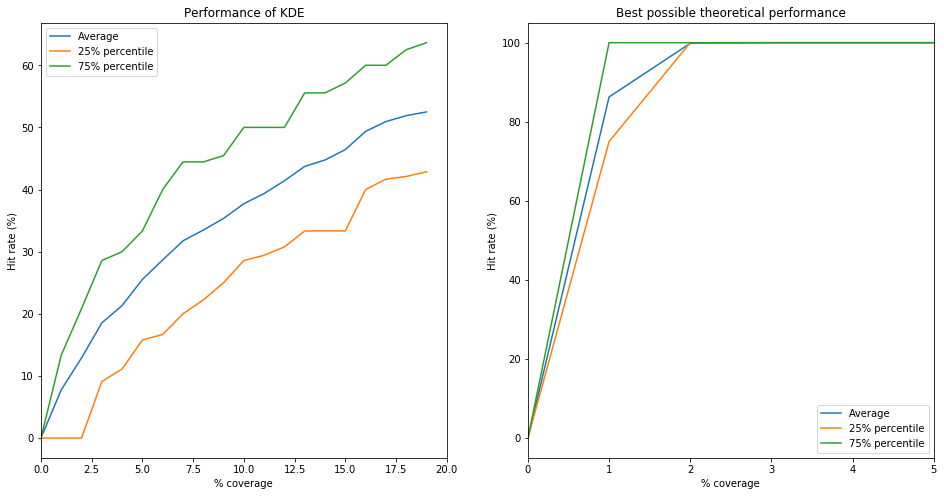

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
for ax, r in zip(axes, [rates, best_possible]):
    avg, low, high = compute_stats(r)
    ax.plot(range(20), avg)
    ax.plot(range(20), low)
    ax.plot(range(20), high)
    ax.legend(["Average", "25% percentile", "75% percentile"])
    ax.set(xlabel="% coverage", ylabel="Hit rate (%)")
    ax.set(xlim=[0,20])
axes[0].set_title("Performance of KDE")
axes[1].set_title("Best possible theoretical performance")
axes[1].set(xlim=[0,5])
None

# Plot the time series

In [37]:
import pandas as pd

In [38]:
frame = pd.DataFrame(rates).T
frame.index.name = "Prediction Date"
frame.columns.name = "% Coverage"
frame.head()

% Coverage,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Prediction Date,,,,,,,,,,,,,,,,,,,,
2011-09-28,0.0,0.285714,0.285714,0.285714,0.285714,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.571429,0.571429
2011-09-29,0.0,0.125000,0.208333,0.208333,0.208333,0.291667,0.333333,0.333333,0.333333,0.333333,0.416667,0.500000,0.541667,0.583333,0.666667,0.666667,0.666667,0.708333,0.708333,0.708333
2011-09-30,0.0,0.222222,0.333333,0.333333,0.333333,0.333333,0.444444,0.555556,0.555556,0.555556,0.555556,0.555556,0.555556,0.555556,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
2011-10-01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
2011-10-02,0.0,0.333333,0.333333,0.333333,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.666667


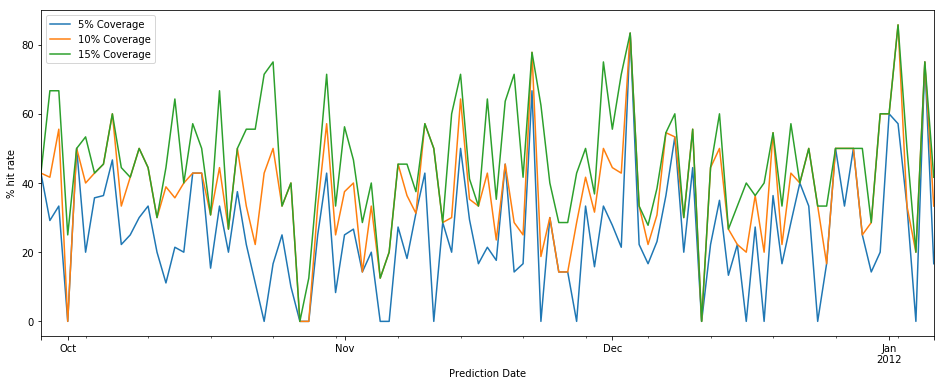

In [39]:
fig, ax = plt.subplots(figsize=(16,6))
(frame[5] * 100).plot(ax=ax)
(frame[10] * 100).plot(ax=ax)
(frame[15] * 100).plot(ax=ax)
ax.set_ylabel("% hit rate")
ax.legend(["{}% Coverage".format(x) for x in [5,10,15]])
None

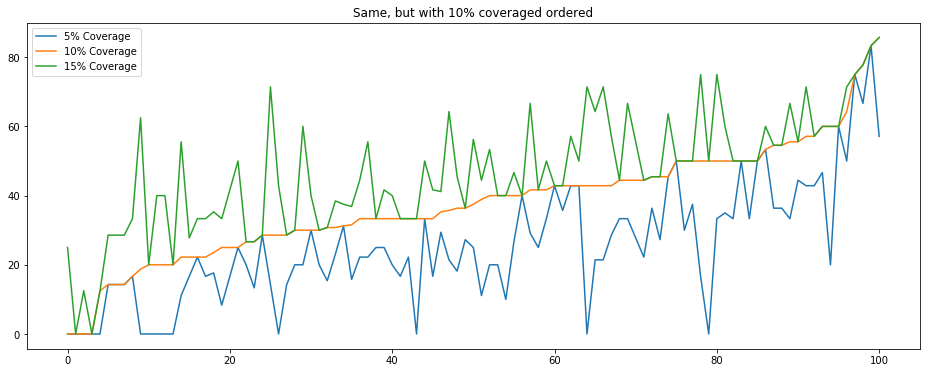

In [40]:
accuracy = [ (frame[5][i], frame[10][i], frame[15][i]) for i in frame.index ]
accuracy.sort(key = lambda x : x[1])
fig, ax = plt.subplots(figsize=(16,6))
for i in [0,1,2]:
    ax.plot(range(len(accuracy)), [x[i]*100 for x in accuracy])
ax.legend(["{}% Coverage".format(x) for x in [5,10,15]])
ax.set_title("Same, but with 10% coveraged ordered")
None